## Advanced Statistical Methods Project P1-B1-C1 by Kundyz Onlabek

### Data generation

Given a sample $S_{n}=\left\{\left(X_{i}, Y_{i}\right): 1 \leq i \leq n\right\}$, where $X_{i}=i / n,  i \in\{1, \ldots, n\}$ are equidistant design points, and $Y_{i}$ 's are generated from the model
$$
Y_{i}=f^{*}\left(X_{i}\right)+\varepsilon_{i}, \quad 1 \leq i \leq n,
$$
where $f^{*}$ is a univariate function on $[0,1]$, and $\varepsilon_{1}, \ldots, \varepsilon_{n}$ are i.i.d. standard Gaussian random variables $\mathcal{N}(0,1)$. The sample size $n$ is set to 200 and the function $f^{*}$ is generated artificially according to the following scheme. 

Consider the Fourier basis $\left\{\psi_{j}(x)\right\}_{j=1}^{n}$ :
$$
\psi_{j}(x)=\left\{\begin{array}{l}
1, \quad \text { if } j=0 \\
\sin (\pi(j+1) x), \quad \text { if } j \text { is odd } \\
\cos (\pi j x), \quad \text { if } j \text { is even. }
\end{array}\right.
$$
The true function $f^{*}$ is then equal to
$$
f(x)=c_{1} \psi_{1}(x)+\cdots+c_{n} \psi_{n}(x),
$$
where the coefficients $c_{1}, \ldots, c_{n}$ are chosen randomly: with $\gamma_{j}$ i.i.d. standard normal,
$$
c_{j}=\left\{\begin{array}{l}
\gamma_{j}, \quad 1 \leq j \leq 10 \\
\frac{\gamma_{j}}{(j-10)^{2}}, \quad 11 \leq j \leq n.
\end{array}\right.
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n = 200
SEED = 0xABCDEF

In [3]:
def psi(x, i):
    if i == 0:
        return 1
    if i % 2:
        return np.sin(np.pi * (i + 1) * x)
    return np.cos(np.pi * i * x)

def f(x, size=n):
    mask = np.concatenate(
        [np.ones(10), 1 / (np.arange(11, n + 1) - 10) ** 2]
        )
    coeffs = mask * np.random.randn(n)
    funs = np.array([psi(x, i) for i in range(1, n + 1)])
    return coeffs @ funs

In [4]:
np.random.seed(SEED)

xi = np.linspace(1/n, 1, n)
yi = f(xi) + np.random.randn(n)

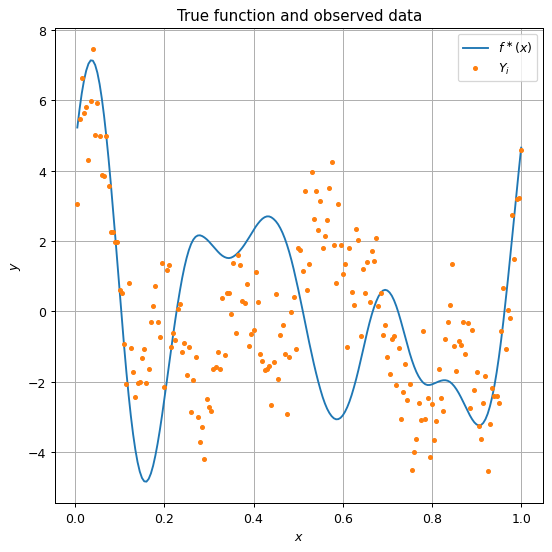

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7), dpi=90)
ax.plot(xi, f(xi), label='$f^\\ast(x)$')
ax.plot(xi, yi, '.', label='$Y_i$')
ax.grid()
ax.legend()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('True function and observed data')
plt.show()

### Function estimation via SURE

The goal is to estimate $f^*(x)$.

Firstly, we approximate $f^*(x)$ choosing a basis from the piecewise constant functions $\left\lbrace  \phi_j(x) \right\rbrace_{j=1}^m$:

Basis functions have the form
$$
    \phi_j(x) = 
    \begin{cases}
        1, & \text{if $x \in \left[a + \left(j - 1\right)l_m, a + jl_m\right)$} \\
        0, & \text{else},
    \end{cases}
$$
where $a = \frac{1}{n}$, $b = 1$, $l_m = \frac{b - a}{m}$. 

For the $m$-th segment $\left[ a - lm, b \right]$ both ends are included.

After we chose a basis for approximation, the next step is to fix a family $M$ of parameters where we are going to find the best one. For each $m \in M$, we compute the design matrix $\mathbf{\Phi} \in \mathbb{R}^{n \times m}$.

The goal is to find the approximation
$$
    Y_i = \sum_{j=1}^m \theta_j\phi_j(X_i), \; i = 1, \ldots, n.
$$
In matrix form,
$
    Y = \mathbf{\Phi} \theta,
$
hence, the elements of the design matrix will be given by $\Phi_{ij} = \phi_{j}(X_i)$.

In [6]:
a = 1 / n
b = 1
def phi(x, j, m):
    assert j >= 1 and j <= m, print(j)
    l = (b - a) / m
    left = a + (j - 1) * l
    right = a + j * l
    if j == m:
        if left <= x <= right:
            return 1
        return 0
    if left <= x < right:
        return 1
    return 0

def design_matrix(m):
    matrix = np.empty((n, m))
    for i in range(n):
        for j in range(m):
            matrix[i, j] = phi(xi[i], j + 1, m)
    return matrix

#### Unbiased risk estimation

$$ \widetilde{\mathscr{R}}_{m}:=\left\|\boldsymbol{Y}-\mathscr{K}_{h} \boldsymbol{Y}\right\|^{2}+2 \sigma^{2} \operatorname{tr} \mathscr{K}_{h} $$

The estimates of vectors of parameters and of the target functional:
\begin{aligned}
&\left\|Y - \Phi_{m} \theta_{m}\right\|^{2} \rightarrow \min _
{\theta_{m}} \Rightarrow \hat{\theta}_{m}=\left(\Phi_{m}^{\top} \Phi_{m}\right)^{-1} \Phi_{m}^{\top} Y=K_{m} Y \\ 
&S_{m}=\left(\Phi_{m}^{\top} \Phi_{m}\right)^{-1} \Phi_{m}^{\top}
\\
&K_{m}=\Phi \left(\Phi_{m}^{\top} \Phi_{m}\right)^{-1} \Phi_{m}^{\top} 
\end{aligned}

\begin{aligned}
\tilde\phi_m = \mathbf{\Phi}_m \hat{\theta}_m = \mathbf{\Phi}_m \left(\mathbf{\Phi}_m^\top \mathbf{\Phi}_m\right)^{-1}\mathbf{\Phi}_m^\top Y = K_m Y.
\end{aligned}

In [7]:
def unbiased_risk_estimate(K, Y, sigma2):
    assert Y.ndim == 1 and K.ndim == 2
    return (Y - K @ Y) @ (Y - K @ Y) + 2 * sigma2 * np.diag(K).sum()

#### True risk estimation

Let $f$ be the vector of the true function values $f^\ast(X_i)$ and $K \equiv \mathcal{K}_m$, $m$ is fixed.
$$
\begin{gather}
\mathcal{R}(\hat{f}) = \mathbb{E} \left\| f - \hat{f} \right\|^2 = \mathbb{E} \left\| f - KY \right\|^2 = \mathbb{E} \left\| f - K(f + \varepsilon) \right\|^2 \\
\left\| f - K(f + \varepsilon) \right\|^2 = \left(f - K(f + \varepsilon)\right)^\top \left(f - K(f + \varepsilon)\right) = \\
= f^\top f - f^\top K \left( f + \varepsilon\right) - \left( f + \varepsilon\right)^\top K^\top f + \left( f + \varepsilon\right)^\top K^\top K \left( f + \varepsilon\right).
\end{gather}
$$

The only random variable of above expression is $\varepsilon \sim \mathcal{N}(0, 1)$. For any deterministic scalar $s$, vector $v$ and matrix $M$ following expectation properties are true: $\mathbb{E}s = s$, $\mathbb{E}\left[c^\top \varepsilon\right] = c^\top \mathbb{E}\varepsilon = c^\top \vec 0 = 0$, $\mathbb{E}\left[\varepsilon^\top M \varepsilon\right] = \sigma^2 \text{tr}M = \text{tr}M.$

After transformation of squared $L_2$ norm of difference between $f$ and $\hat{f}$ and application of expectations, we obtain final expression for true risk:
$$
    R(\hat{f}) = f^\top \left(I - K - K^\top + K^\top K\right) f + \text{tr} \left( K^\top K \right).
$$

In [8]:
def true_risk(f, K):
    assert f.ndim == 1 and K.ndim == 2
    return f.T @ f - f.T @ K @ f - f.T @ K.T @ f + f.T @ K.T @ K @ f + np.diag(K.T @ K).sum()

#### Comparison of unbiased and true risks

In [9]:
size = 100
M = np.linspace(10, 150, size).astype('int')
# M = np.arange(10, 151)

In [10]:
risk_estimates = np.empty(size)
true_risk_values = np.empty(size)
for idx, m in enumerate(M):
    Phi_m = design_matrix(m)
    K_m = Phi_m @ np.linalg.inv(Phi_m.T @ Phi_m) @ Phi_m.T
    risk_estimates[idx] = unbiased_risk_estimate(K_m, yi, 1)
    true_risk_values[idx] = true_risk(f(xi), K_m)

In [11]:
idx_hat = np.argmin(risk_estimates)
idx_star = np.argmin(true_risk_values)

m_hat = M[idx_hat]
m_star = M[idx_star]

print(f'Parameter value chosen from the unbiased risk: {m_hat}')
print(f'Parameter value chosen from the true risk: {m_star}')

Parameter value chosen from the unbiased risk: 29
Parameter value chosen from the true risk: 36


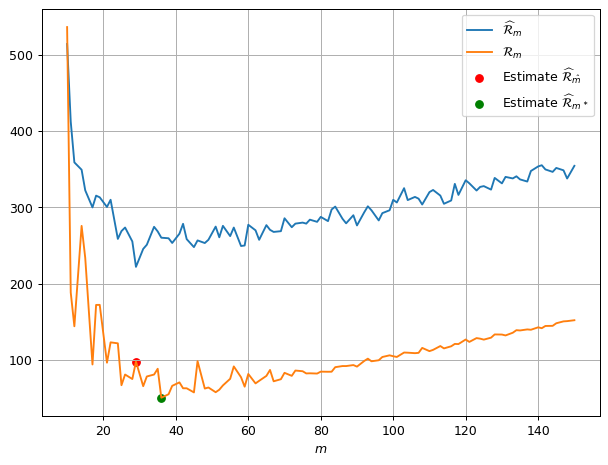

In [12]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=90)
ax.plot(M, risk_estimates, label='$\\widehat{\\mathcal{R}}_{m}$')
ax.plot(M, true_risk_values, label='$\\mathcal{R}_{m}$')
ax.scatter(m_hat, true_risk_values[idx_hat], c='r', label='Estimate $\\widehat{\\mathcal{R}}_{\hat{m}}$')
ax.scatter(m_star, true_risk_values[idx_star], c='g', label='Estimate $\\widehat{\\mathcal{R}}_{m^\\ast}$')
ax.grid()
ax.legend()
ax.set_xlabel('$m$')
# ax.set_ylabel('$\\widehat{\\mathcal{R}}_m$')
plt.show()